# Install required packages

In [1]:
!pip install --upgrade pip
!pip install face_recognition ultralytics scikit-learn seaborn opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.1 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 89.4 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 91.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 54.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 113.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 111.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 30.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 52.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━

# Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import face_recognition as fr
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from ultralytics import YOLO
import time
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Create DataFrame with image paths

In [3]:
def create_dataframe(base_path):
    data = []
    for label in os.listdir(base_path):
        label_path = os.path.join(base_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(label_path, img_file)
                    data.append([img_path, label])
    return pd.DataFrame(data, columns=['image_path', 'label'])

# Path to your dataset

In [4]:
base_path = '/kaggle/input/face-recog/Original Images'
df = create_dataframe(base_path)
print(f"Dataset size: {len(df)} images")
print(df['label'].value_counts())

Dataset size: 809 images
label
Brad Pitt           120
Robert Downey Jr    113
Hugh Jackman        112
Henry Cavill        106
Courtney Cox         80
Roger Federer        77
Margot Robbie        72
Elizabeth Olsen      71
Tom Cruise           58
Name: count, dtype: int64


# Plot distribution

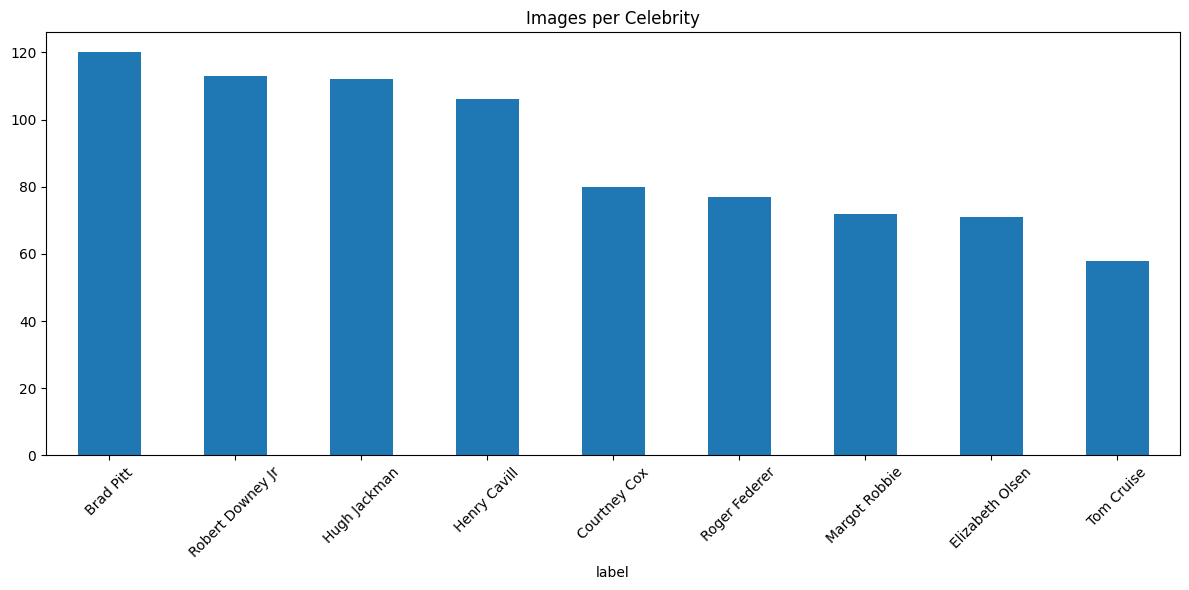

In [5]:
plt.figure(figsize=(12,6))
df['label'].value_counts().plot(kind='bar')
plt.title('Images per Celebrity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Initialize models

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo_face_model = YOLO('/kaggle/input/yolov8/other/default/1/yolov8n-face.pt').to(device)
haar_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Face encoding with different detection methods

In [7]:
def encode_images(df, method='yolo'):
    encodings = []
    labels = []
    image_paths = []
    face_locations = []
    detection_times = []
    failed_detections = 0

    for idx, row in df.iterrows():
        image = fr.load_image_file(row['image_path'])
        locations = []
        
        # Convert to RGB for OpenCV (Haar requires BGR but we'll convert to grayscale)
        image_bgr = cv.cvtColor(image, cv.COLOR_RGB2BGR)

        # Face detection
        start_time = time.time()
        if method == 'hog':
            # HOG method from face_recognition
            locations = fr.face_locations(image)
        elif method == 'yolo':
            # YOLOv8 face detection
            results = yolo_face_model(image, verbose=False)
            boxes = results[0].boxes.xyxy.cpu().numpy()
            for box in boxes:
                x1, y1, x2, y2 = box[:4]
                locations.append((y1, x2, y2, x1))  # Convert to (top, right, bottom, left)
        elif method == 'haar':
            # Haar Cascade detection
            gray = cv.cvtColor(image_bgr, cv.COLOR_BGR2GRAY)
            haar_boxes = haar_cascade.detectMultiScale(
                gray, 
                scaleFactor=1.1, 
                minNeighbors=5,
                minSize=(30, 30),
                flags=cv.CASCADE_SCALE_IMAGE
            )
            for (x, y, w, h) in haar_boxes:
                # Convert to (top, right, bottom, left)
                locations.append((y, x+w, y+h, x))
                
        detection_time = time.time() - start_time
        detection_times.append(detection_time)

        if locations:
            # Use the first detected face
            encoding = fr.face_encodings(image, known_face_locations=[locations[0]])[0]
            encodings.append(encoding)
            labels.append(row['label'])
            image_paths.append(row['image_path'])
            face_locations.append(locations[0])
        else:
            failed_detections += 1
            print(f"No face found in {row['image_path']} using {method.upper()}")

    return encodings, labels, image_paths, face_locations, detection_times, failed_detections

# Compare detection methods

In [8]:
print("Evaluating detection methods...")
methods = ['haar', 'hog', 'yolo']  # Ordered from weakest to strongest
results = {}

for method in methods:
    print(f"\nProcessing with {method.upper()} detection...")
    X, y, paths, locs, times, failed = encode_images(df, method=method)
    detection_rate = (len(df) - failed) / len(df)
    avg_time = np.mean(times) * 1000  # Convert to milliseconds

    results[method] = {
        'X': X,
        'y': y,
        'paths': paths,
        'locs': locs,
        'detection_rate': detection_rate,
        'avg_time_ms': avg_time,
        'failed': failed
    }

    print(f"{method.upper()} Detection Rate: {detection_rate:.2%}")
    print(f"{method.upper()} Average Detection Time: {avg_time:.2f} ms")
    print(f"{method.upper()} Failed Detections: {failed}")

Evaluating detection methods...

Processing with HAAR detection...
No face found in /kaggle/input/face-recog/Original Images/Tom Cruise/Tom Cruise_39.jpg using HAAR
No face found in /kaggle/input/face-recog/Original Images/Roger Federer/Roger Federer_25.jpg using HAAR
No face found in /kaggle/input/face-recog/Original Images/Roger Federer/Roger Federer_28.jpg using HAAR
No face found in /kaggle/input/face-recog/Original Images/Roger Federer/Roger Federer_19.jpg using HAAR
No face found in /kaggle/input/face-recog/Original Images/Roger Federer/Roger Federer_55.jpg using HAAR
No face found in /kaggle/input/face-recog/Original Images/Roger Federer/Roger Federer_9.jpg using HAAR
No face found in /kaggle/input/face-recog/Original Images/Roger Federer/Roger Federer_59.jpg using HAAR
No face found in /kaggle/input/face-recog/Original Images/Roger Federer/Roger Federer_23.jpg using HAAR
No face found in /kaggle/input/face-recog/Original Images/Roger Federer/Roger Federer_32.jpg using HAAR
No f

# Compare detection performance

In [9]:
detection_comparison = pd.DataFrame({
    'Method': methods,
    'Detection Rate': [results[m]['detection_rate'] for m in methods],
    'Avg Time (ms)': [results[m]['avg_time_ms'] for m in methods],
    'Failed Detections': [results[m]['failed'] for m in methods]
})

print("\nDetection Method Comparison:")
print(detection_comparison)


Detection Method Comparison:
  Method  Detection Rate  Avg Time (ms)  Failed Detections
0   haar        0.976514     518.566823                 19
1    hog        0.996292     742.499148                  3
2   yolo        0.997528      15.657864                  2


# Visualization of performance metrics

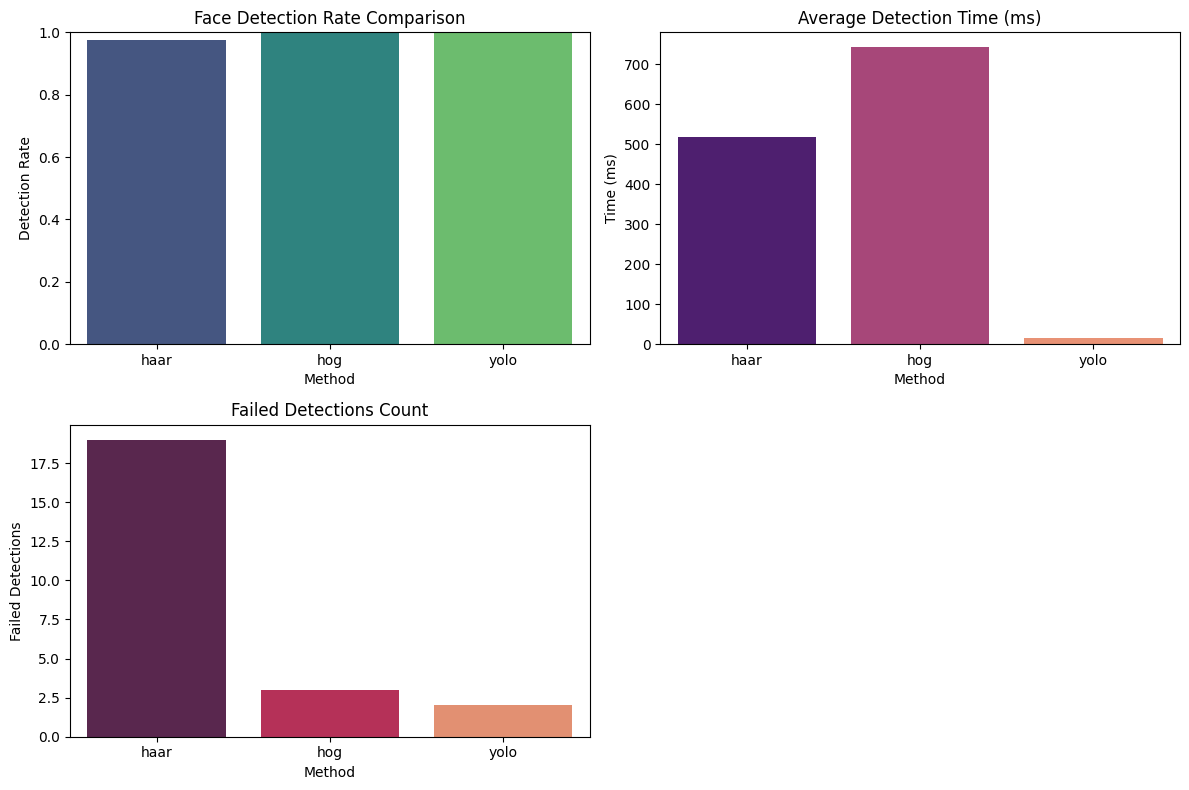

In [10]:
# Visualization of performance metrics
plt.figure(figsize=(12, 8))

# Detection Rate Comparison
plt.subplot(2, 2, 1)
sns.barplot(x='Method', y='Detection Rate', data=detection_comparison, palette='viridis')
plt.title('Face Detection Rate Comparison')
plt.ylim(0, 1.0)

# Speed Comparison
plt.subplot(2, 2, 2)
sns.barplot(x='Method', y='Avg Time (ms)', data=detection_comparison, palette='magma')
plt.title('Average Detection Time (ms)')
plt.ylabel('Time (ms)')

# Failed Detections
plt.subplot(2, 2, 3)
sns.barplot(x='Method', y='Failed Detections', data=detection_comparison, palette='rocket')
plt.title('Failed Detections Count')

plt.tight_layout()
plt.show()

# Train classifier using best method (YOLO)

In [11]:
print("\nTraining classifier with YOLO detections...")
X_train, X_test, y_train, y_test = train_test_split(
    results['yolo']['X'], 
    results['yolo']['y'], 
    test_size=0.2,
    random_state=42
)

# KNN Classifier
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
print(f"KNN Accuracy: {knn_score:.2%}")

# SVM Classifier
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
svm_score = svm.score(X_test, y_test)
print(f"SVM Accuracy: {svm_score:.2%}")


Training classifier with YOLO detections...
KNN Accuracy: 37.04%
SVM Accuracy: 35.80%


# Detailed report

In [12]:
y_pred = svm.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                  precision    recall  f1-score   support

       Brad Pitt       0.23      0.63      0.34        27
    Courtney Cox       1.00      0.27      0.43        11
 Elizabeth Olsen       1.00      0.33      0.50        18
    Henry Cavill       0.90      0.45      0.60        20
    Hugh Jackman       0.14      0.30      0.19        23
   Margot Robbie       0.83      0.36      0.50        14
Robert Downey Jr       0.64      0.35      0.45        20
   Roger Federer       0.00      0.00      0.00        18
      Tom Cruise       1.00      0.36      0.53        11

        accuracy                           0.36       162
       macro avg       0.64      0.34      0.39       162
    weighted avg       0.57      0.36      0.38       162



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Confusion matrix

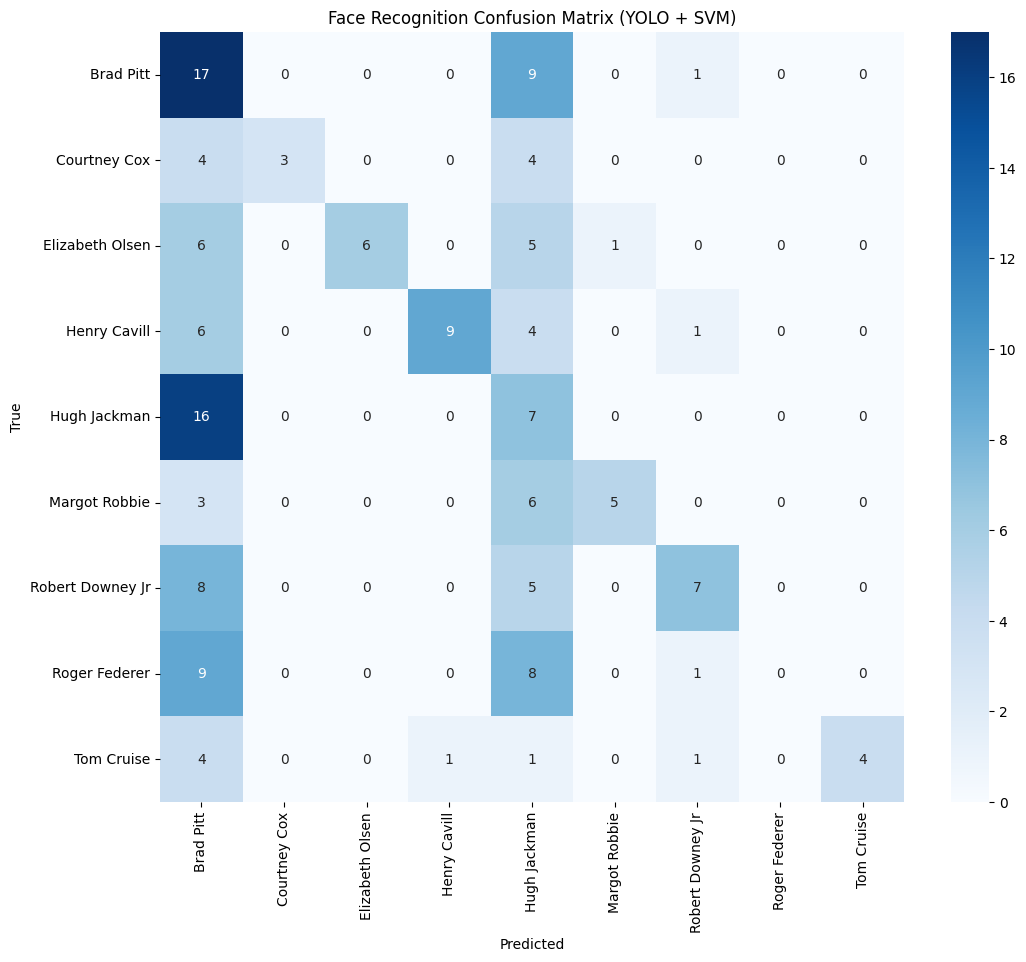

In [13]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=svm.classes_, 
            yticklabels=svm.classes_)
plt.title('Face Recognition Confusion Matrix (YOLO + SVM)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

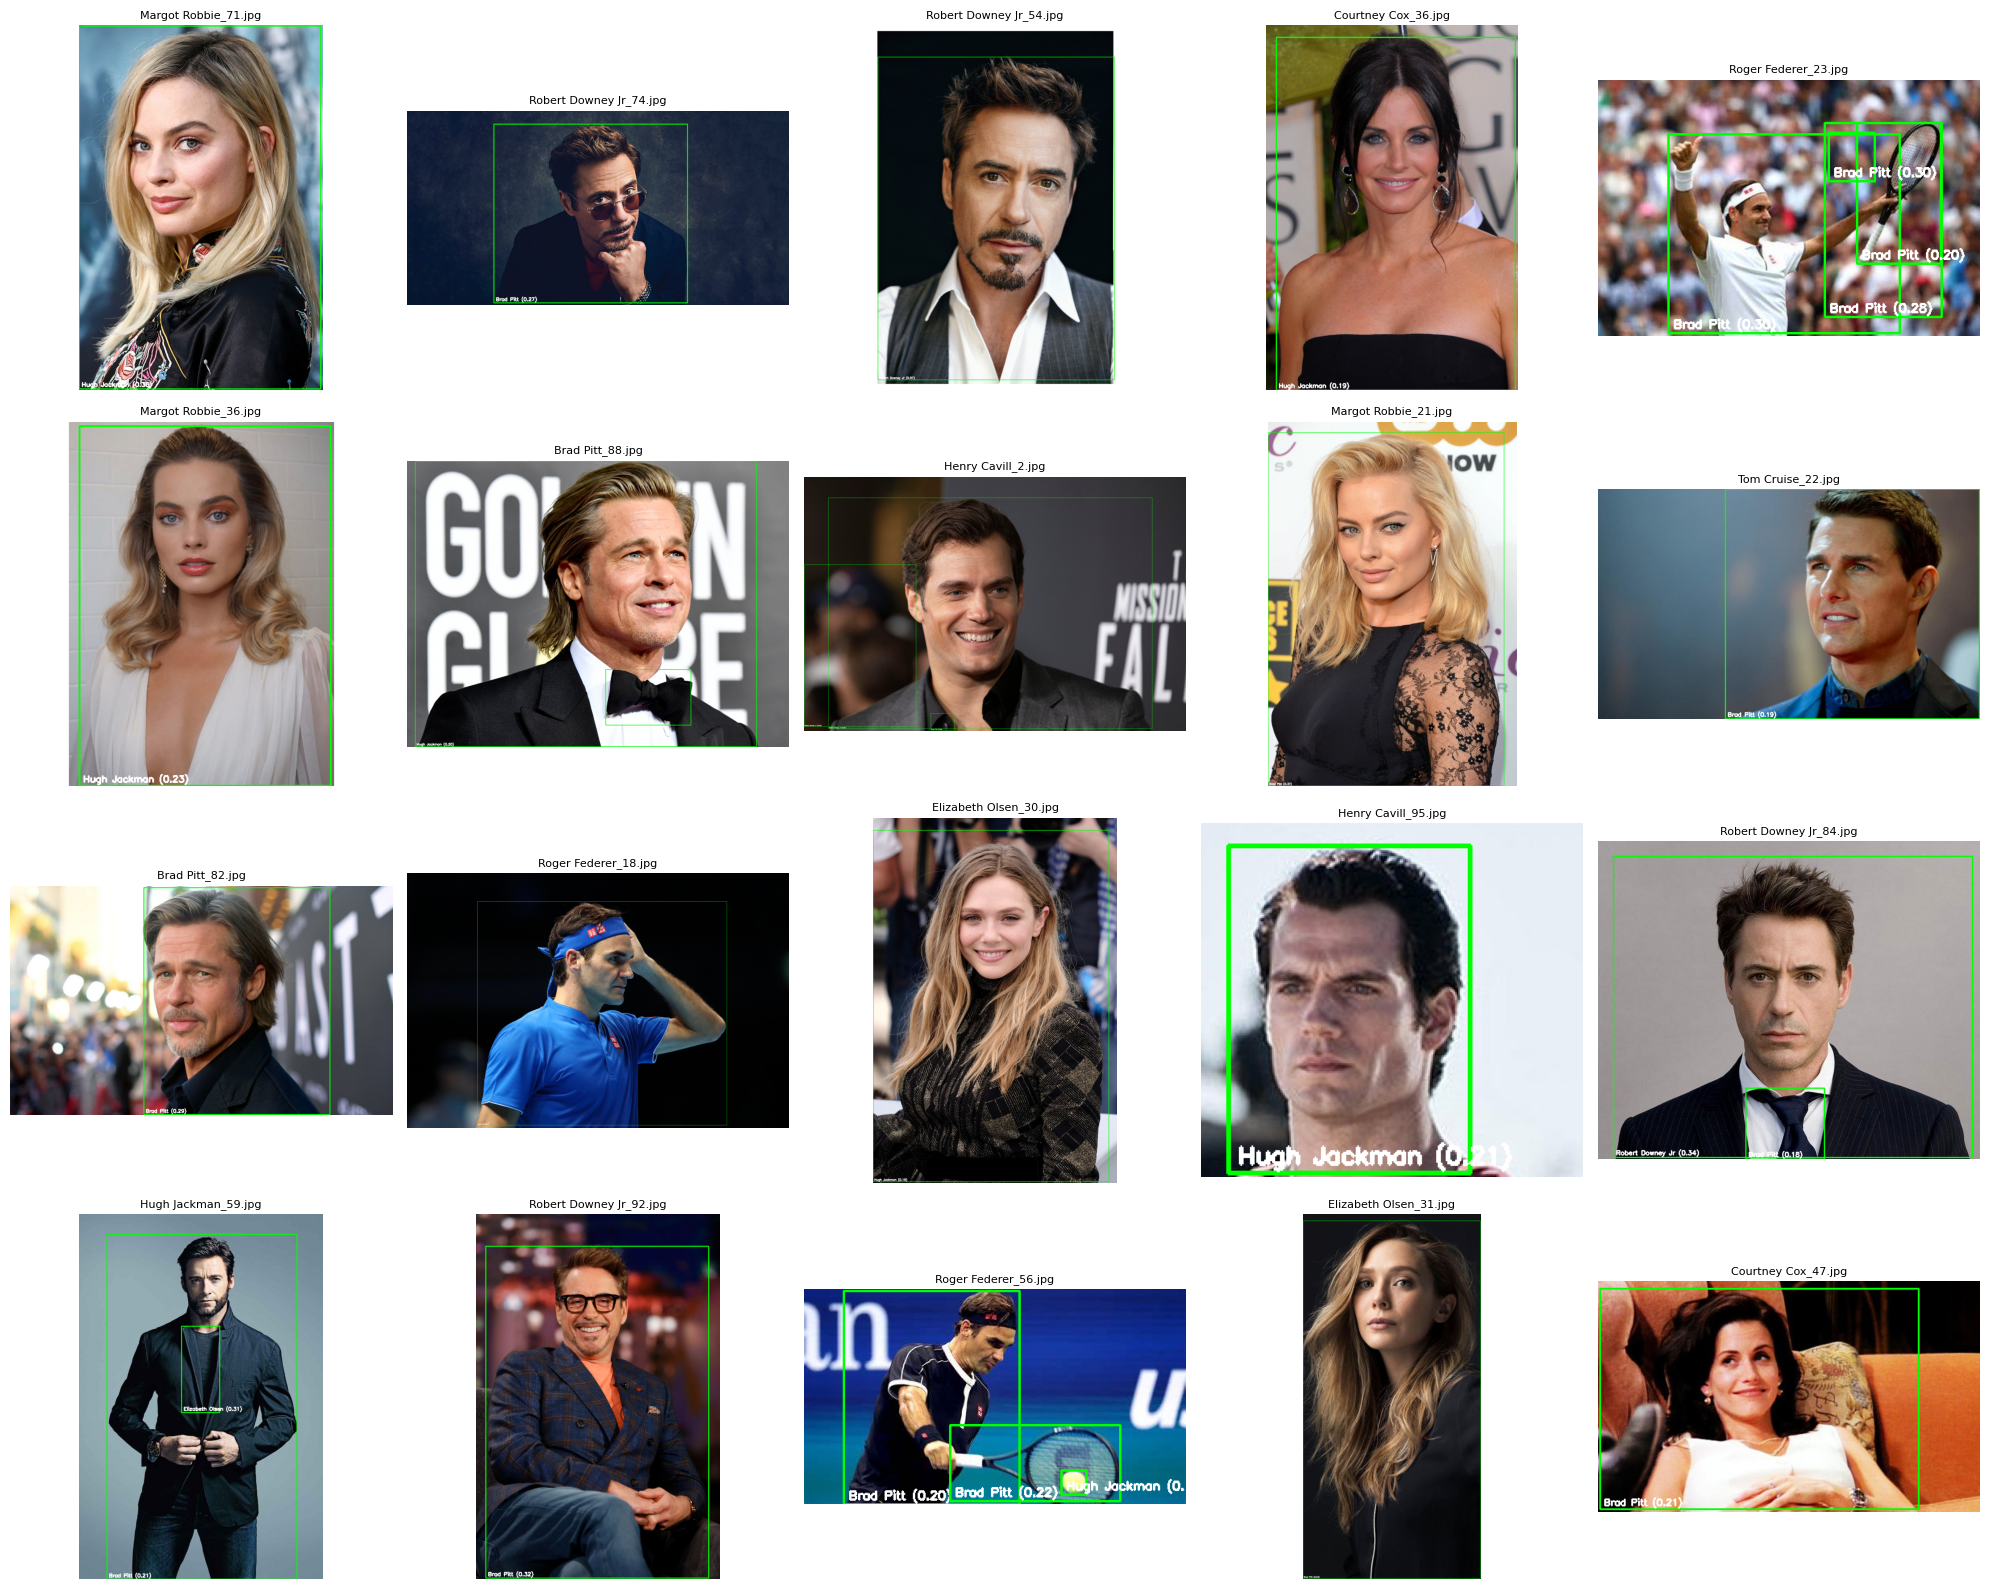

In [14]:
import math

# 1) Modify test_sample to return the image array instead of showing it:
def annotate_face(image_path, model=svm, detection_method='yolo'):
    image = fr.load_image_file(image_path)
    image_bgr = cv.cvtColor(image, cv.COLOR_RGB2BGR)
    
    # Detect faces
    if detection_method == 'yolo':
        results = yolo_face_model(image, verbose=False)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        locations = [(box[1], box[2], box[3], box[0]) for box in boxes]
    elif detection_method == 'hog':
        locations = fr.face_locations(image)
    else:  # haar
        gray = cv.cvtColor(image_bgr, cv.COLOR_BGR2GRAY)
        haar_boxes = haar_cascade.detectMultiScale(gray, 1.1, 5)
        locations = [(y, x+w, y+h, x) for (x, y, w, h) in haar_boxes]
    
    # Annotate
    for loc in locations:
        encoding = fr.face_encodings(image, known_face_locations=[loc])[0]
        pred = model.predict([encoding])[0]
        prob = model.predict_proba([encoding]).max()
        top, right, bottom, left = loc
        cv.rectangle(image_bgr, (int(left), int(top)), (int(right), int(bottom)), (0,255,0), 2)
        cv.putText(image_bgr, f"{pred} ({prob:.2f})",
                   (int(left)+6, int(bottom)-6),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

    # back to RGB
    return cv.cvtColor(image_bgr, cv.COLOR_BGR2RGB)

# 2) Sample 20 paths
sample_paths = df.sample(20)['image_path'].values

# 3) Plot in a 4×5 grid
cols = 5
rows = math.ceil(len(sample_paths) / cols)
plt.figure(figsize=(cols * 4, rows * 4))

for idx, img_path in enumerate(sample_paths):
    img = annotate_face(img_path, model=svm, detection_method='yolo')  # or 'hog'/'haar'
    ax = plt.subplot(rows, cols, idx + 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{os.path.basename(img_path)}", fontsize=8)

plt.tight_layout()
plt.show()